In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Idea problemu

Wyobraźmy sobie, że jesteśmy w kasynie i mamy przed sobą automaty do gry. Takie automaty są popularnie nazywane "jednorękimi bandytami". Z których automatów korzystać, by zmaksymalizować swój dochód z wizyty w kasynie? Jako gracze nie wiemy, jakie jest prawdopodobieństwo zdobycia nagrody dla poszczególnych maszyn. Nie wiemy także, jaka nagroda czeka nas w przypadku zdobycia nagrody. O tym, jaka jest nasza nagroda, dowiadujemy się dopiero po jej zdobyciu. Gdyby nagroda była znana, problem byłby banalny - ciągnęlibyśmy za ramię, gdzie nagroda będzie największa. 

Jest to tzw. problem wielorękiego bandyty (ang. multi-handed bandit). Opisuje on sytuację gry w kasynie (stąd wzięła się jego nazwa), ale nie tylko. Polega on zawsze na tym, że mamy środowisko, w którym mamy do wyboru różne opcje, natomiast nie wiemy, jakie nagrody może nam przynieść wybór poszczególnych opcji. Naszym celem jest zmaksymalizowanie nagrody w długim horyzoncie czasowym poprzez odpowiednie wybieranie opcji. 

Przykładem problemu, który można sprowadzić do problemu wielorękiego bandyty jest wybór strategii przy leczeniu choroby. Mamy do dyspozycji różne akcje, które możemy zastosować podczas terapii i nie wiemy, które z nich są skuteczne. Chcemy się dowiedzieć, jak najlepiej przeprowadzić terapię, by zmaksymalizować funkcję celu (czyli wyleczyć pacjenta).

# Sformalizowanie problemu

Chcemy znaleźć, która akcja przynosi największe zyski (i w związku z tym - której akcji należy używać).
Dobrym sposobem na oszacowanie wartości akcji jest wyznaczenie średniej nagród z przeszłości dla danej akcji.
$$Q_t(a_i) = \frac{\sum_{k=0}^{t-1} R_k I_k^i}{\sum_{k=0}^{t-1} I_k^i}$$
gdzie 
1. $Q_t(a_i)$ to przewidytana wartość nagrody, wyznaczona dla i-tego ramienia w czasie t
2. $I_k^i$ = 1, gdy $k$-ta akcja była akcją $a_i$ lub 0 wpp
3. $R_k$ to nagroda uzyskana w k-tej akcji.

## Podstawowy algorytm

Opiszę podstawową wersję algorytmu. W dalszej części pracy będę wprowadzał modyfikacje do podstawowego modelu.

Dla każdego ramienia a:
1. Q(a) = 0
2. N(a) = 0 # jest to licznik pociągnięć dla ramienia

W pętli wykonujemy następujące kroki:
1. Wybierz ramię, które ma największe Q (bazujemy tutaj na przekonaniu, że jeśli do tej pory ramię dswało największe nagrody, to warto za nie ciągnąć w przyszłości
2. Zagraj za pomocą ręki j i sprawdź, jaką nagrodę otrzymasz: $R = getRewardFromBandit(j)$ 

3. Uaktualnij wartość przewidywanej nagrody. Jest tutaj używany pewien trik matematyczny (patrz Sutton, Barto: str 31)

$Q(a) = Q(a) + \frac{1}{N(a)} [R - Q(a)]$

## Algorytm epsilon-zachłanny

Powyższy algorytm ma pewną poważną wadę. Gdy pociągniemy za wajchę i dostaniemy nagrodę, będziemy sądzili, że jest ona najlepsza, bo dała nam najlepszy wynik (inne wajchy rzeczywiście nic nie dały, ale też i nie mogły nic dać). Przy użyciu takiej zachłannej strategii możemy zatrzymać się w stanie, który daje najlepsze wyniki, ale tylko lokalnie. Być może przy użyciu innej wajchy moglibyśmy zyskać więcej.

Dlatego oprócz _eksploatacji_, czyli czerpania zysków z dotychczas znanych rozwiązań ważna jest także _eksploracja_, czyli szukanie rozwiązań, które mogą poprawić nasze zyski długofalowo. 

_Eksploracja_ polega na losowym wybraniu akcji innej niż ta, której wybór mógłby być sugerowany przez największą wartość oczekiwanej nagrody. 

Wprowadzamy zatem wpspółczynnik $\epsilon$ (równy zazwyczaj 0.1). Podczas gry, z prawdopodobieństwem $\epsilon$ będziemy ciągnąć za losową wajchę. 

Zatem w tym przypadku, krok algorytmu:
1. Wybierz ramię, które ma największe Q (bazujemy tutaj na przekonaniu, że jeśli do tej pory ramię dawało największe nagrody, to warto za nie ciągnąć w przyszłości. 

Zmieni się na:
1. Wybierz ramię, które ma największe Q lub losowo z prawdopodobieństwem $\epsilon$ - inne ramię

## W jaki sposób wyznaczana jest nagroda za pociągnięcie danego ramienia?

Każde z ramion otrzyma wartość oczekiwaną, wylosowaną z rozkładu Gaussa o parametrach {mi = 0, sigma = 5}.

In [34]:
mi = 0
sigma = 5

O wielkości otrzymanej nagrody decydują dwa czynniki:
1. Prawdopodobieńtwo otrzymania nagrody (czyli w ogóle chodzi o to, czy dostaniemy jakąś nagrodę, czy nie) przy pociągnięciu za dane ramię. Może ono być ustalone na dwa sposoby:
    * Arbitralnie dla każdego ramienia prawdopodobieństwo równe 1
    * Arbitralnie dla każdego ramienia to samo prawdopodobieństwo (nierówne 1)
    * Prawdopobobieństwo różne dla każdego ramienia. 

2. W przypadku, gdy nagroda będzie, dla pociągniętego ramienia losujemy nagrodę z rozkładu Gaussa z parametrami {mi = wartość oczekiwana dla danej ręki, sigma = 5}. Zakładamy, że nagrody nie będą ujemne (będę "obcinać do zera" ujemne wartości). Możliwą modyfikacją przy obliczaniu nagrody jest wykorzystanie funkcji nagrody. Argumentem funkcji nagrody jest wartość wylosowana. Domyślnie - funkcja jest liniowa. Przetestuję także funkcję kwadratową - jako jedną z funkcji wypukłych

Wyjaśnienie: W trzecim przypadku wyboru prawdopodobieństwa, prawdopodonieństwa będą dystrybuatną rozkładu o mi=0 w punkcie, będącą wartością oczekiwaną danego ramienia.

Przetestuję różne konfiguracje.

# Implementacja i testy

Po wstępie teoretycznym możemy przejść do implementacji i testów. To, co testuję, będę opisywał na bieżąco.

## Definiujemy liczbę ramion k-rękiego bandyty

In [103]:
k = 10

## Wartości oczekiwane

In [104]:
expectedValues = np.random.normal(loc=mi, scale=sigma, size=k)

In [105]:
expectedValues

array([-0.78184249, -3.69118108, -3.77999317,  8.78360564, -3.57578706,
       -2.88862668,  2.77948531, -6.49838041,  0.79589239,  1.64154579])

Prawdopodobieństwa wylosowania nagrody dla trzeciej metody losowania prawdopodobieństwa

In [106]:
probabilities = [stats.norm.cdf(x, mi, sigma) for x in expectedValues]
probabilities

[0.43787128306835188,
 0.23018545930480316,
 0.22482500760881208,
 0.96051732282612701,
 0.23725589057034363,
 0.28172478548274493,
 0.71085938671043447,
 0.096856005473772266,
 0.56323587040232548,
 0.62866103949338403]

## Dostępne funkcje nagrody 

In [107]:
functions = {
    "lin" : lambda x : x,
    "sqrt": lambda x : x * x
}

### Poniższa funkcja zwraca nagrodę od j-tego bandyty, wykorzystując podaną funkcję nagrody i wektor prawdopodobieństwa

In [115]:
def getRewardFromBandit(j, fun, probabilities):
    rand = np.random.rand()

    if rand < probabilities[j] :
        return max(fun(np.random.normal(loc = expectedValues[j], scale = sigma)), 0)
    else:
        return 0

### Poniższa funkcja implementuje algorytm bandyty. Zwraca sumaryczne wartości nagród

In [136]:
def playBandit(eps, steps, probabilities, fun = functions["lin"]):

    Q = np.zeros(k)
    N = np.zeros(k)

    Qs = []

    # Uruchamiamy cały algorytm wiele razy zmieniając ilość kroków w algorytmie. Suma nagród powinna się zmieniać.
    for step in range(1, steps):
        for i in range(step):
            # Wybierzmy j - indeks ręki, za którą pociągniemy    
            rand = np.random.rand()
            if rand <= eps:
                j = np.random.randint(k)
            else:
                maxBandits = np.where(Q == np.max(Q))[0]
                j = random.choice(maxBandits)

            R = getRewardFromBandit(j, fun, probabilities)

            N[j] = N[j] + 1
            Q[j] = Q[j] + (1/N[j]) * (R - Q[j])

        # Dodajemy sumę nagród
        Qs.append(sum(Q))

    return (range(1, steps), Qs)

# Test 1: Porównanie algorytmów: zachłannego i eps-zachłannego (dla eps = 0.05 i eps = 0.1

In [117]:
greedy = playBandit(0, 1000, probabilities)
eps005 = playBandit(0.05, 1000, probabilities)
eps01 = playBandit(0.1, 1000, probabilities)

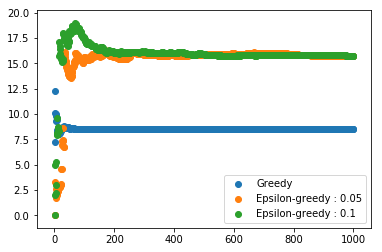

In [123]:
greedyPlot = plt.scatter(greedy[0], greedy[1])
eps005Plot = plt.scatter(eps005[0], eps005[1])
eps01Plot  = plt.scatter(eps01[0], eps01[1])

legend = plt.legend([greedyPlot, eps005Plot, eps01Plot], ['Greedy', 'Epsilon-greedy : 0.05', 'Epsilon-greedy : 0.1'])

Spójrzmy na początek wykresu (pomoże to w interpretacji wyników):

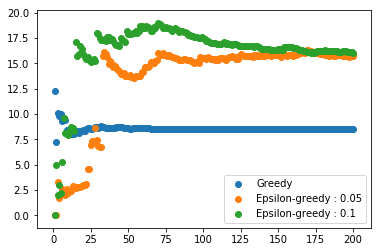

In [124]:
greedyPlot = plt.scatter(greedy[0][0:200], greedy[1][0:200])
eps005Plot = plt.scatter(eps005[0][0:200], eps005[1][0:200])
eps01Plot  = plt.scatter(eps01[0][0:200], eps01[1][0:200])

legend = plt.legend([greedyPlot, eps005Plot, eps01Plot], ['Greedy', 'Epsilon-greedy : 0.05', 'Epsilon-greedy : 0.1'])

Zachłanny wybór akcji nie jest dobrym wyjściem. Co prawda - w pierwszych krokach strategia zachłanna daje dobre wyniki. Natomiast korzyści płynące z eksploracji są dobrze widoczne w ujęciu długoterminowym. Większy współczynnik eksploracji wydaje się dawać lepsze wyniki, natomiast warto sprawdzić, czy przy dużych wartościach wyniki zaczną się pogarszać.

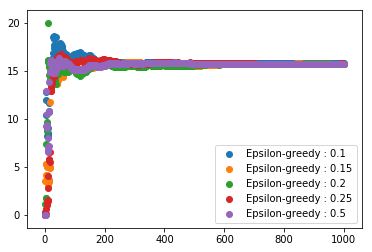

In [120]:
eps010 = playBandit(0.1, 1000, probabilities)
eps015 = playBandit(0.15, 1000, probabilities)
eps020 = playBandit(0.2, 1000, probabilities)
eps025 = playBandit(0.25, 1000, probabilities)
eps050 = playBandit(0.5, 1000, probabilities)

eps010Plot  = plt.scatter(eps010[0], eps010[1])
eps015Plot  = plt.scatter(eps015[0], eps015[1])
eps020Plot  = plt.scatter(eps020[0], eps020[1])
eps025Plot  = plt.scatter(eps025[0], eps025[1])
eps050Plot  = plt.scatter(eps050[0], eps050[1])

legend = plt.legend([eps010Plot, eps015Plot,eps020Plot,eps025Plot,eps050Plot], 
                    ['Epsilon-greedy : 0.1','Epsilon-greedy : 0.15', 'Epsilon-greedy : 0.2', 'Epsilon-greedy : 0.25', 'Epsilon-greedy : 0.5'])

Z wykresu wynika, że efektywność nie zmniejsza się znacząco

# Test 2: Porównanie dwóch algorytmów eps-zachłannych (z tym samym eps), ale z innymi prawdopodobieństwami nagrody

Przewidujemy, że tam, gdzie wyższe prawdopodobieństwo uzyskania nagrody, tam wyższa suma nagród (a co za tym idzie - także i średnia nagród). Ponadto, jeśli prawdopodobieństwa mają się do siebie jak 2 do 1, to nagrody też powinny być w takim stosunku do siebie.

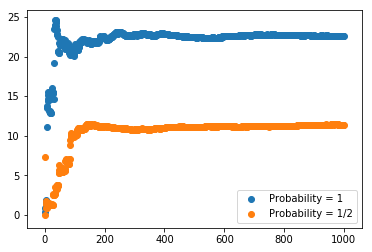

In [133]:
probFull = playBandit(0.05, 1000, np.repeat(1, k))
probHalf = playBandit(0.05, 1000, np.repeat(1/2, k))

probFullPlot  = plt.scatter(probFull[0], probFull[1])
probHalfPlot  = plt.scatter(probHalf[0], probHalf[1])

legend = plt.legend([probFullPlot, probHalfPlot], ['Probability = 1', 'Probability = 1/2'])

Wyniki zgadzają się z przewidywaniami

# Test 3: Porównanie wyników dla różnych funkcji nagrody

Spodziewamy się, że w przypadku użycia funkcji kwadratowej do obliczania nagrody, wartości nagród będą dużo większe (mniej więcej: kwadratowo większe). 

Tak się dzieje w praktyce:

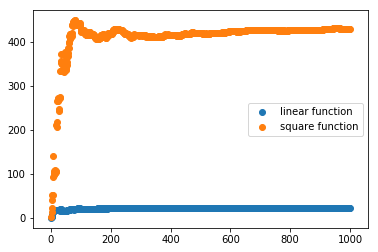

In [137]:
linear = playBandit(0.05, 1000, np.repeat(1, k), fun=functions["lin"])
square = playBandit(0.05, 1000, np.repeat(1, k), fun=functions["sqrt"])

linearPlot  = plt.scatter(linear[0], linear[1])
squarePlot  = plt.scatter(square[0], square[1])

legend = plt.legend([linearPlot, squarePlot], ['linear function', 'square function'])

# Modyfikacje metody

Problem wielorękiego bandyty można rozszerzać na wiele sposobów. Opiszę i zaimplementuję dwa z nich.

## Problem niestacjonarny

Do tej pory nie zakładaliśmy, że wartości oczekiwane nagród (i rozkłady tych nagród) mogą się zmienać podczas gry. Był to tak zwany problem stacjonarny. 

W problemie niestacjonarnym rozkład może się zmieniać. Dlatego powinniśmy wprowadzić mechanizm, który pozwoliłby na premiowanie niedawno wykonanych akcji (są one najbardziej aktualne, więc i najbardziej miarodajne). Użycie średniej arytmetycznej do obliczania wartości stanów jest złym pomysłem, bo premiuje wszystkie akcje jednakowo.

Możemy zmodyfikować wzór służący do obliczania wartości stanów w sposób następujący:

$$Q_{t+1}=\alpha R_t + (1 - \alpha)Q_t$$
gdzie $\alpha \in (0,1\rbrack$ - stała określająca wpływ najnowszej nagrody na oszacowanie akcji

In [143]:
def playBanditAlfa(eps, steps, probabilities, fun = functions["lin"], alfa = 0.2):

    Q = np.zeros(k)
    N = np.zeros(k)

    Qs = []

    # Uruchamiamy cały algorytm wiele razy zmieniając ilość kroków w algorytmie. Suma nagród powinna się zmieniać.
    for step in range(1, steps):
        for i in range(step):
            # Wybierzmy j - indeks ręki, za którą pociągniemy    
            rand = np.random.rand()
            if rand <= eps:
                j = np.random.randint(k)
            else:
                maxBandits = np.where(Q == np.max(Q))[0]
                j = random.choice(maxBandits)

            R = getRewardFromBandit(j, fun, probabilities)

            N[j] = N[j] + 1
            Q[j] = Q[j] * (1-alfa) + R * alfa

        # Dodajemy sumę nagród
        Qs.append(sum(Q))

    return (range(1, steps), Qs)

Nasz obecny problem jest nadal stacjonarny, rozkłady prawdopodobieństwa nie zmieniają się. Sprawdźmy, w jaki sposób algorytm przeznaczony do rozwiązywania problemów niestacjonarny poradzi sobie na problemie stacjonarnym:

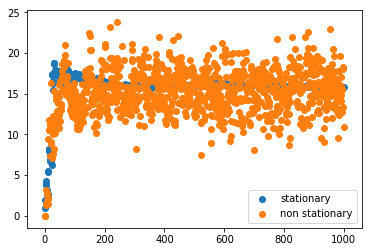

In [144]:
stationary = playBandit(0.05, 1000, probabilities)
nonStationary = playBanditAlfa(0.05, 1000, probabilities, alfa =0.2)

stationaryPlot  = plt.scatter(stationary[0], stationary[1])
nonStationaryPlot  = plt.scatter(nonStationary[0], nonStationary[1])

legend = plt.legend([stationaryPlot, nonStationaryPlot], ['stationary', 'non stationary'])

Algorytm niestacjonarny działa źle, jego wyniki cały czas się wachają.

W wersji podstawowej, algorytm eksploatuje najlepszą akcję. W przypadku niestacjonarnym - algorytm "zapomina", jaka była najlepsza akcja. Ten algorytm nie jest odporny na to, że w pewnym momencie akcja, która była do tej pory najlepsza da małą nagrodę. Będzie interesowało go to, że nagroda jest mała, a nie to, że historycznie akcja ta dawała największe nagrody, bo "zapomina" o tym.

## Inna interpretacja funkcji nagrody

W innej interpretacji problemu, wartości prawdopodobieństwa wystąpienia dla ramion bierzemy tak, jak w opcji trzeciej, to znaczy: prawdopobobieństwo różne dla każdego ramienia, prawdopodobieństwo jest dystrybuantą w punkcie, będącym wartością oczekiwaną. 

Zupełnie inna jest interpretacja wartości funkcji nagrody. Wielkość nagrody będzie zależała tylko od ilości pociągnięć za ramiona. Funkcje nagrody nadal będą liniowe lub kwadratowe. 

Można różnie interpretować ilość pociągnięć za ramiona:
1. Ilość użyć wszystkich ramion w sumie - licznik użyć jest globalny
2. Ilość użyć poszeczgólnych ramion - licznik jest per ramiono.

Przetestuję obie opcje.

In [152]:
def getRewardFromBandit2(j, fun, probabilities, N, isCounterGlobal = True):
    rand = np.random.rand()
    
    if rand < probabilities[j] :
        if isCounterGlobal:
            arg = np.sum(N)
        else:
            arg = N[j]
            
        return fun(arg)
    else:
        return 0

In [153]:
def playBandit2(eps, steps, probabilities, fun = functions["lin"], isCounterGlobal = True):

    Q = np.zeros(k)
    N = np.zeros(k)

    Qs = []

    # Uruchamiamy cały algorytm wiele razy zmieniając ilość kroków w algorytmie. Suma nagród powinna się zmieniać.
    for step in range(1, steps):
        for i in range(step):
            # Wybierzmy j - indeks ręki, za którą pociągniemy    
            rand = np.random.rand()
            if rand <= eps:
                j = np.random.randint(k)
            else:
                maxBandits = np.where(Q == np.max(Q))[0]
                j = random.choice(maxBandits)

            R = getRewardFromBandit2(j, fun, probabilities, N, isCounterGlobal)

            N[j] = N[j] + 1
            Q[j] = Q[j] + (1/N[j]) * (R - Q[j])

        # Dodajemy sumę nagród
        Qs.append(sum(Q))

    return (range(1, steps), Qs)

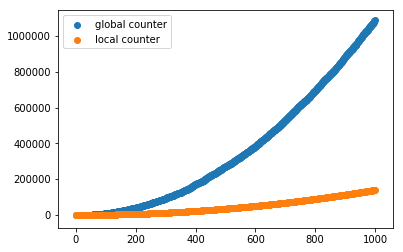

In [155]:
globalCounter = playBandit2(0.05, 1000, probabilities, isCounterGlobal=True)
localCounter = playBandit2(0.05, 1000, probabilities, isCounterGlobal=False)

globalCounterPlot  = plt.scatter(globalCounter[0], globalCounter[1])
localCounterPlot  = plt.scatter(localCounter[0], localCounter[1])

legend = plt.legend([globalCounterPlot, localCounterPlot], ['global counter', 'local counter'])

Konsekwencja zmiany interpretacji licznika (globalny / lokalny) była dość łatwa do przewidzenia. Licznik globalny zawsze będzie niemniejszy niż lokalny. Skoro nagroda zależy od licznika, to wartość nagrody będzie stale wzrastała.

Taka interpretacja jest dość dziwna, gdyż zakłada, że nagrody rosną w nieskończoność. Natomiast także przy takiej interpretacji można zbadać wpływ epsilon-zachłanności: 

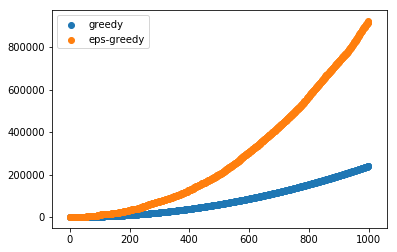

In [157]:
greedy = playBandit2(0.00, 1000, probabilities, isCounterGlobal=True)
eps = playBandit2(0.05, 1000, probabilities, isCounterGlobal=True)

greedyPlot  = plt.scatter(greedy[0], greedy[1])
epsPlot  = plt.scatter(eps[0], eps[1])

legend = plt.legend([greedyPlot, epsPlot], ['greedy', 'eps-greedy'])

Oczywiście, nagrody rosną szybciej w przypadku użycia strategii epsilon-zachłannej.